In [1]:
import jupyter_black

import os, sys
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader

from PIL import Image

if not "/usr/src" in sys.path:
    sys.path.append("/usr/src")

jupyter_black.load()

In [2]:
# Custom modules
from dataset import create_cell_dataset, augmentation_cells
from unet import UNet
from diffusion import Diffusion
from utils_diffusion import (
    train,
    count_fid_metric,
    show_grid_samples,
    generate_and_save_samples,
)

In [3]:
# Dirs
cell_dir = "/usr/src/data/separated_cells"
new_cell_dir = "/usr/src/data/separated_cells_new"
sample_dir = "/usr/src/samples_cell"

In [ ]:
# Expanding of cell dataset using trabsforms
augmentation_cells(cell_dir, new_cell_dir)

In [4]:
# Settings
image_size = 64
channels = 1
batch_size = 70
device = "cuda" if torch.cuda.is_available() else "cpu"

# Create the dataset of cells
cell_dataset = create_cell_dataset(new_cell_dir, image_size)

# Create the dataloader for training
train_loader = DataLoader(cell_dataset, batch_size=batch_size, shuffle=True)

In [5]:
# Chech dataset and trainloader

print(f"Len of dataset:  {len(cell_dataset)} images")
print(f"Len of trainloader:  {len(train_loader)} batches")
print(f"Shape of batch:  {next(iter(train_loader)).shape}")

Len of dataset:  7640 images
Len of trainloader:  110 batches
Shape of batch:  torch.Size([70, 1, 64, 64])


In [6]:
# Initialization of the diffusion

timesteps = 400
diffusion = Diffusion(timesteps)

In [5]:
# Initialization of the denoising model

model = UNet(
    img_dim=image_size,
    img_channels=channels,
    in_channels=32,
    channel_mults=(1, 2, 4, 8),
)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# Training model

epochs = 25
log_path = "logging_cells"
log_interval = len(train_loader) // 4

loss_progress = train(
    model, diffusion, timesteps, train_loader, epochs, optimizer, device, log_path, log_interval
)

Text(0.5, 1.0, 'Loss per each step')

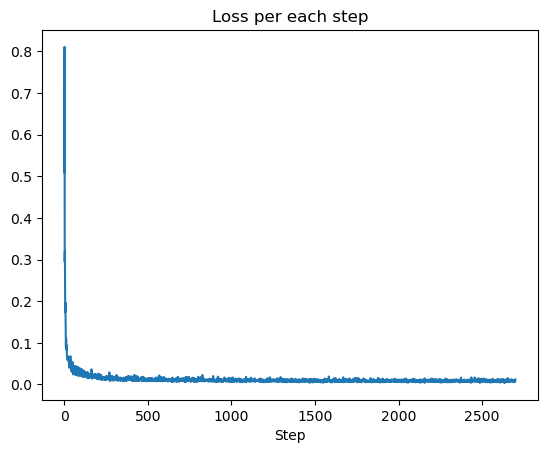

In [11]:
plt.plot(loss_progress)
plt.xlabel("Step")
plt.title("Loss per each step")

In [ ]:
# Save trained model

torch.save(model, f"cell_denoise_model_{epochs}_epochs.pt")

In [ ]:
# Load pretrained model

model = torch.load("cell_denoise_model_25_epochs.pt")
model.eval()

sampling loop time step:   0%|          | 0/400 [00:00<?, ?it/s]

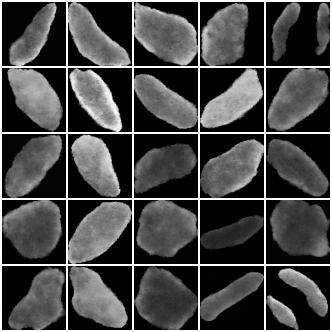

In [8]:
# Create grid of generated samples and show it

samples = show_grid_samples(25, diffusion, model, image_size, channels, "cute_grid")

In [9]:
# Generate many new separate samples and save them

generate_and_save_samples(sample_dir, 20, 20, diffusion, model, image_size, channels)

sampling loop time step:   0%|          | 0/400 [00:00<?, ?it/s]

In [8]:
# Count FID metric

feature = 2048
print(f"feature = {feature}, FID =", count_fid_metric(train_loader, diffusion, model, image_size, channels, 100, feature))

sampling loop time step:   0%|          | 0/400 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/400 [00:00<?, ?it/s]

140 samples are generated, time = 28.611 sec
FID is computed, time = 42.027 sec
tensor(171.2493)
